This notebook investigates the test power vs. the number of test locations J in an incremental way. Specifically, we conjectured that the test power using $\mathcal{T}$, the set of $J$ locations should not be higher than the test power obtained by using $\mathcal{T} \cup \{t_{J+1}\}$

In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.ex.exglobal as exglo
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import freqopttest.glo as glo
import freqopttest.plot as plot
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 14
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)

In [102]:
# sample source 
n = 500
dim = 30
seed = 13
#ss = data.SSGaussMeanDiff(dim, my=0.5)
ss = data.SSGaussVarDiff(dim)
#ss = data.SSSameGauss(dim)
#ss = data.SSBlobs()
dim = ss.dim()
tst_data = ss.sample(n, seed=seed)
tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=seed+82)

J = 2
alpha = 0.01
T = tst.MeanEmbeddingTest.init_locs_2randn(tr, J, seed=seed+1)
#T = np.random.randn(J, dim)

In [103]:
med = util.meddistance(tr.stack_xy(), 800)
list_gwidth = np.hstack( ( (med**2) *(2.0**np.linspace(-5, 5, 30) ) ) )
list_gwidth.sort()
besti, powers = tst.MeanEmbeddingTest.grid_search_gwidth(tr, T, list_gwidth, alpha)


i:  0, lamb:  5.29, gwidth:  1.83, power: 0.2939
i:  1, lamb:  7.01, gwidth:  2.32, power: 0.4180
i:  2, lamb:  9.14, gwidth:  2.95, power: 0.5623
i:  3, lamb:  11.2, gwidth:  3.74, power: 0.6835
i:  4, lamb:  12.8, gwidth:  4.75, power: 0.7571
i:  5, lamb:  13.6, gwidth:  6.04, power: 0.7877
i:  6, lamb:  13.6, gwidth:  7.67, power: 0.7884
i:  7, lamb:  13.1, gwidth:  9.74, power: 0.7698
i:  8, lamb:  12.4, gwidth:  12.4, power: 0.7395
i:  9, lamb:  11.6, gwidth:  15.7, power: 0.7032
i: 10, lamb:  10.9, gwidth:    20, power: 0.6656
i: 11, lamb:  10.3, gwidth:  25.3, power: 0.6298
i: 12, lamb:  9.71, gwidth:  32.2, power: 0.5976
i: 13, lamb:  9.26, gwidth:  40.9, power: 0.5697
i: 14, lamb:  8.89, gwidth:  51.9, power: 0.5463
i: 15, lamb:  8.59, gwidth:  65.9, power: 0.5269
i: 16, lamb:  8.36, gwidth:  83.7, power: 0.5112
i: 17, lamb:  8.17, gwidth:   106, power: 0.4985
i: 18, lamb:  8.02, gwidth:   135, power: 0.4883
i: 19, lamb:   7.9, gwidth:   171, power: 0.4801
i: 20, lamb:   7.8, 

In [104]:
# test with the best Gaussian with 
best_width = list_gwidth[besti]
met_grid = tst.MeanEmbeddingTest(T, best_width, alpha)
met_grid.perform_test(te)

{'alpha': 0.01,
 'h0_rejected': False,
 'pvalue': 0.19280973764486886,
 'test_stat': 3.2921027832486223}

In [105]:
def draw_t(tst_data, seed=None):
    # Fit one Gaussian to the X,Y data. 
    if seed is not None:
        rand_state = np.random.get_state()
        np.random.seed(seed)

    xy = tst_data.stack_xy()
    # fit a Gaussian to each of X, Y
    m = np.mean(xy, 0)
    cov = np.cov(xy.T)
    t = np.random.multivariate_normal(m, cov, 1)
    
    # reset the seed back
    if seed is not None:
        np.random.set_state(rand_state)
    return t


('stats increasing: %s', True)
('stats increasing: %s', True)
('stats increasing: %s', True)
('stats increasing: %s', True)
('stats increasing: %s', True)
('stats increasing: %s', True)


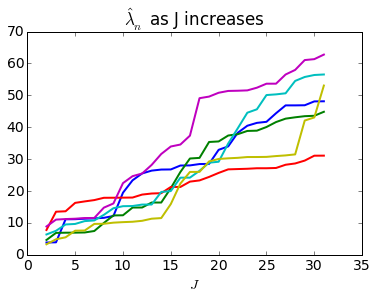

In [123]:
def simulate_stats_trajectory(T):
    Tn = T
    # add one new test location at a time.
    trials = 30
    test_stats = np.zeros(trials)
    for i in range(trials):
        # draw new location
        t = draw_t(tr)
        Tn = np.vstack((Tn, t))
        met = tst.MeanEmbeddingTest(Tn, best_width, alpha)
        tresult = met.perform_test(te)
        test_stats[i] = tresult['test_stat']
    return test_stats, Tn

for rep in range(6):
    test_stats, Tn = simulate_stats_trajectory(T)
    plt.plot(np.arange(len(T), len(Tn)), test_stats)
    print('stats increasing: %s', np.all(np.diff(test_stats)>=0) )
plt.xlabel('$J$')
plt.title('$\hat{\lambda}_n$ as J increases')

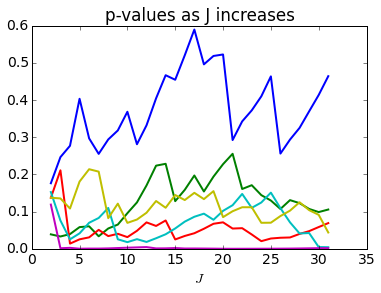

In [127]:
# plot p-value. 
for r in range(6):
    test_stats, Tn = simulate_stats_trajectory(T)
    Js = np.arange(len(T), len(Tn))
    pvals = [stats.chi2.sf(s, df=J) for s, J in zip(test_stats, Js)]
    plt.plot(Js, pvals)
plt.xlabel('$J$')
plt.title('p-values as J increases')